In [ ]:
#setup 
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
!pip install scikit-learn
import sklearn

mpl.rcParams['figure.figsize'] = (4, 3)
mpl.rcParams['axes.grid'] = False


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
new_table = pd.read_csv('https://raw.githubusercontent.com/giobbu/App_Traff_Forecast_DeapLearn/master/data/Flow_BEL_street_30min.csv')

In [ ]:
# this source: 
# the https://www.kaggle.com/code/giobbu/seasonal-persistence-model/notebook#Results-Comparison-between-Seasonal-model-(baseline)-and-LSTM-encoder-decoder-model
# selects the roads that have an average traffic flow of 10 or larger, we also do this, this code is from the notebook listed above 

table_index = new_table.iloc[:,1:]
ALL_STREETS = list(table_index.columns.values)

mean_flow =[]
new_street=[]

mean_value = 20

for street in ALL_STREETS:
    
    single_street=table_index[street]
    mean = np.mean(single_street)
    mean_flow.append(mean)
    new_street.append(street)
    
    
df_mean_flow = pd.DataFrame({'street_index':new_street, 'mean_flow': mean_flow})
print('')
print(df_mean_flow.head())
print('')

STREETS = df_mean_flow[(df_mean_flow['mean_flow'] >= mean_value)] 
STREETS = STREETS.sort_values(by=['street_index'])
STREETS = list(STREETS.street_index)

keys_dim = 1683
keys_dim_time = 1686

print('considering a average traffic flow of ' + str(mean_value)+' per street')
print('')
print('mean traffic flow '+str(mean_value)+ ' ---> number of street segments: ' + str(len(STREETS)))


  street_index  mean_flow
0          0.0   4.048023
1          1.0  16.350282
2          2.0   6.511299
3          3.0   7.681850
4          4.0   9.484463

considering a average traffic flow of 20 per street

mean traffic flow 20 ---> number of street segments: 1683


In [ ]:
new_table['datetime'] = pd.to_datetime(new_table['datetime'])

<ipython-input-7-ffee7ced4756>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  plt.plot(new_table['datetime'],new_table.mean(axis = 1))


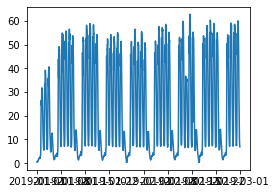

In [ ]:
plt.plot(new_table['datetime'],new_table.mean(axis = 1))

In [ ]:
from tensorflow.python.ops.gen_array_ops import fake_quant_with_min_max_vars_per_channel
#we need to create "windows" in the data --> 
#X: input tensor : use a window of size s, lets say 5, as X
#Y: output vector : traffic for hour six predicted based on the previous window 

#this is the window function for multiple input features and multiple output pairs
#what's the difference between df_to_x_y2 and df_to_x_y --> the first one is just for one input vector (ie the data from one street) this 
#version accepts many columns of data (all the street values and the transformed time data)
def df_to_x_y2(positional_data,non_positional, window_size): 
  #df_as_np = df.to_numpy()
  print(positional_data.shape)
  print(non_positional.shape)
  X = []
  Y = []
  for i in range((len(positional_data))-window_size-1):
    row = [r for r in positional_data[i:i+window_size]]
    
    #The line below makes the last value in the batch 0 (relative to what we are predicting, 
    #traffic flow rate, the positional information is still encoded )
    row.append(positional_data[i+window_size+1] - non_positional[i+window_size+1]) 
    X.append(row)
    
    label = [non_positional[i+window_size][0:]] 
    Y.append(label)
  return np.array(X), np.array(Y)

In [ ]:
#this is for transforming datetime to recognizable inputs 
#sin and cos transformation for hour of the day 
df = new_table
df = df[STREETS + ['datetime']] 
 #this removes all of the streets with aveage flow <10 

df.head()

time = df['datetime'].to_numpy()

In [ ]:
def positional_encoding(df):
  import datetime as dt
  from sklearn.preprocessing import MinMaxScaler
  df = pd.Series(df)
  hour = df.dt.hour.to_numpy().astype('float32')
  hour_sin = np.sin(hour*2* np.pi/23)
  hour_cos = np.cos(hour*2* np.pi/23)
  
  day_of_week = df.dt.dayofweek.to_numpy()
  day_of_week_scaler = MinMaxScaler(feature_range=(-1, 1))
  day_of_week = day_of_week.reshape(-1, 1)
  day_of_week = day_of_week_scaler.fit_transform(day_of_week)
  day_of_week = day_of_week[:,0]
  
  pos_encoding_val = hour_sin + hour_cos + day_of_week
  pos_encoding_val = pos_encoding_val.reshape(-1,1)
  final_scaler = MinMaxScaler(feature_range=(0,1))
  pos_encoding_val = final_scaler.fit_transform(pos_encoding_val)
  return pos_encoding_val
  

In [ ]:
#test positoinal_encoding function 
positional_encoding(time)

array([[0.56847003],
       [0.56847003],
       [0.61674907],
       ...,
       [0.64311181],
       [0.70677715],
       [0.70677715]])

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, date_time_info,time_weight):
    super().__init__()
    from sklearn.preprocessing import MinMaxScaler
    self.time_weight = time_weight
    self.scaler = MinMaxScaler(feature_range=(0,1))
    self.pos_encoding = positional_encoding(date_time_info)

  def call(self, x):
    print(x.shape)
    print(type(x))
    print(x)
    length = tf.shape(x)[1]
    x = self.scaler.fit_transform(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    print(self.pos_encoding.shape)
    x_positioned = np.add(x*(1-self.time_weight), (self.time_weight * self.pos_encoding))
    print(x.shape)
    x_final,y_final= df_to_x_y2(x_positioned,x,window_size=12) 
    x_final = tf.constant(x_final)
    y_final = tf.constant(y_final)
    return x_final,y_final

In [ ]:
#testing the positional embedding class 
positional_em = PositionalEmbedding(time,0.4)
positional_em2 = PositionalEmbedding(time,0)

print('shape1',positional_em(df[STREETS].to_numpy())[0][0])
print('shape2',positional_em2(df[STREETS].to_numpy())[0][0])

x1_df = df[STREETS + ['datetime']].to_numpy()

(2832, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 2.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  1.  1.  0.]
 [ 3.  1.  0. ...  1.  0.  0.]
 ...
 [31. 14.  4. ... 19.  8. 13.]
 [29. 16.  1. ... 16.  6. 27.]
 [21. 27.  6. ... 14.  4. 15.]], shape=(2832, 1683), dtype=float32)
(2832, 1)
(2832, 1683)
(2832, 1683)
(2832, 1683)
shape1 tf.Tensor(
[[0.23351046 0.22738801 0.22738801 ... 0.22738801 0.22738801 0.22738801]
 [0.23044924 0.22738801 0.22738801 ... 0.22999671 0.23538801 0.22738801]
 [0.2558833  0.25038061 0.24669963 ... 0.24930832 0.24669963 0.24669963]
 ...
 [0.2455972  0.24621695 0.24711613 ... 0.24514467 0.25053597 0.24474186]
 [0.24253597 0.24253597 0.24711613 ... 0.24253597 0.25053597 0.24694774]
 [0.21949069 0.21416954 0.2215315  ... 0.21805324 0.2215315  0.2215315 ]], shape=(13, 1683), dtype=float64)
(2832, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 2.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  1.  1.  0.]
 [ 3.  1.

In [ ]:
#@title util.py 
# coding=utf-8
# Copyright 2022 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Keras-based einsum layer.
Copied from
https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/dense_einsum.py.
"""
# pylint: disable=g-classes-have-attributes

_CHR_IDX = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m"]


#@tf.keras.utils.register_keras_serializable(package="Text")
class DenseEinsum(tf.keras.layers.Layer):
  """A densely connected layer that uses tf.einsum as the backing computation.
  This layer can perform einsum calculations of arbitrary dimensionality.
  Arguments:
    output_shape: Positive integer or tuple, dimensionality of the output space.
    num_summed_dimensions: The number of dimensions to sum over. Standard 2D
      matmul should use 1, 3D matmul should use 2, and so forth.
    activation: Activation function to use. If you don't specify anything, no
      activation is applied
      (ie. "linear" activation: `a(x) = x`).
    use_bias: Boolean, whether the layer uses a bias vector.
    kernel_initializer: Initializer for the `kernel` weights matrix.
    bias_initializer: Initializer for the bias vector.
    kernel_regularizer: Regularizer function applied to the `kernel` weights
      matrix.
    bias_regularizer: Regularizer function applied to the bias vector.
    activity_regularizer: Regularizer function applied to the output of the
      layer (its "activation")..
    kernel_constraint: Constraint function applied to the `kernel` weights
      matrix.
    bias_constraint: Constraint function applied to the bias vector.
  Input shape:
    N-D tensor with shape: `(batch_size, ..., input_dim)`. The most common
      situation would be a 2D input with shape `(batch_size, input_dim)`.
  Output shape:
    N-D tensor with shape: `(batch_size, ..., units)`. For instance, for a 2D
      input with shape `(batch_size, input_dim)`, the output would have shape
      `(batch_size, units)`.
  """

  def __init__(self,
               output_shape,
               num_summed_dimensions=1,
               activation=None,
               use_bias=True,
               kernel_initializer="glorot_uniform",
               bias_initializer="zeros",
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(DenseEinsum, self).__init__(**kwargs)
    self._output_shape = output_shape if isinstance(
        output_shape, (list, tuple)) else (output_shape,)
    self._activation = tf.keras.activations.get(activation)
    self._use_bias = use_bias
    self._kernel_initializer = tf.keras.initializers.get(kernel_initializer)
    self._bias_initializer = tf.keras.initializers.get(bias_initializer)
    self._kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
    self._bias_regularizer = tf.keras.regularizers.get(bias_regularizer)
    self._kernel_constraint = tf.keras.constraints.get(kernel_constraint)
    self._bias_constraint = tf.keras.constraints.get(bias_constraint)
    self._num_summed_dimensions = num_summed_dimensions
    self._einsum_string = None

  def _build_einsum_string(self, free_input_dims, bound_dims, output_dims):
    input_str = ""
    kernel_str = ""
    output_str = ""
    letter_offset = 0
    for i in range(free_input_dims):
      char = _CHR_IDX[i + letter_offset]
      input_str += char
      output_str += char

    letter_offset += free_input_dims
    for i in range(bound_dims):
      char = _CHR_IDX[i + letter_offset]
      input_str += char
      kernel_str += char

    letter_offset += bound_dims
    for i in range(output_dims):
      char = _CHR_IDX[i + letter_offset]
      kernel_str += char
      output_str += char

    return input_str + "," + kernel_str + "->" + output_str

  def build(self, input_shape):
    input_shape = tf.TensorShape(input_shape)
    input_rank = input_shape.rank
    free_input_dims = input_rank - self._num_summed_dimensions
    output_dims = len(self._output_shape)

    self._einsum_string = self._build_einsum_string(free_input_dims,
                                                    self._num_summed_dimensions,
                                                    output_dims)

    # This is only saved for testing purposes.
    self._kernel_shape = (
        input_shape[free_input_dims:].concatenate(self._output_shape))

    self._kernel = self.add_weight(
        "kernel",
        shape=self._kernel_shape,
        initializer=self._kernel_initializer,
        regularizer=self._kernel_regularizer,
        constraint=self._kernel_constraint,
        dtype=self.dtype,
        trainable=True)
    if self._use_bias:
      self._bias = self.add_weight(
          "bias",
          shape=self._output_shape,
          initializer=self._bias_initializer,
          regularizer=self._bias_regularizer,
          constraint=self._bias_constraint,
          dtype=self.dtype,
          trainable=True)
    else:
      self._bias = None
    super(DenseEinsum, self).build(input_shape)

  def get_config(self):
    config = {
        "output_shape":
            self._output_shape,
        "num_summed_dimensions":
            self._num_summed_dimensions,
        "activation":
            tf.keras.activations.serialize(self._activation),
        "use_bias":
            self._use_bias,
        "kernel_initializer":
            tf.keras.initializers.serialize(self._kernel_initializer),
        "bias_initializer":
            tf.keras.initializers.serialize(self._bias_initializer),
        "kernel_regularizer":
            tf.keras.regularizers.serialize(self._kernel_regularizer),
        "bias_regularizer":
            tf.keras.regularizers.serialize(self._bias_regularizer),
        "activity_regularizer":
            tf.keras.regularizers.serialize(self._activity_regularizer),
        "kernel_constraint":
            tf.keras.constraints.serialize(self._kernel_constraint),
        "bias_constraint":
            tf.keras.constraints.serialize(self._bias_constraint)
    }
    base_config = super(DenseEinsum, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def call(self, inputs):
    ret = tf.einsum(self._einsum_string, inputs, self._kernel)
    if self._use_bias:
      ret += self._bias
    if self._activation is not None:
      ret = self._activation(ret)
    return ret

In [ ]:
# coding=utf-8
# Copyright 2022 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Implementation of multiheaded FAVOR-attention & FAVOR-self-attention layers.
Prefix Sum Tensorflow implementation by Valerii Likhosherstov.
"""
import math
import numpy as np
import tensorflow as tf

BIG_CONSTANT = 1e8

def create_products_of_givens_rotations(dim, seed):
  r"""Constructs a 2D-tensor which is a product of Givens random rotations.
  Constructs a 2D-tensor of the form G_1 * ... * G_k, where G_i is a Givens
  random rotation. The resulting tensor mimics a matrix taken uniformly at
  random form the orthogonal group.
  Args:
    dim: number of rows/columns of the resulting 2D-tensor.
    seed: random seed.
  Returns:
    The product of Givens random rotations.
  """
  nb_givens_rotations = dim * int(math.ceil(math.log(float(dim))))
  q = np.eye(dim, dim)
  np.random.seed(seed)
  for _ in range(nb_givens_rotations):
    random_angle = math.pi * np.random.uniform()
    random_indices = np.random.choice(dim, 2)
    index_i = min(random_indices[0], random_indices[1])
    index_j = max(random_indices[0], random_indices[1])
    slice_i = q[index_i]
    slice_j = q[index_j]
    new_slice_i = math.cos(random_angle) * slice_i + math.sin(
        random_angle) * slice_j
    new_slice_j = -math.sin(random_angle) * slice_i + math.cos(
        random_angle) * slice_j
    q[index_i] = new_slice_i
    q[index_j] = new_slice_j
  return tf.cast(tf.constant(q), dtype=tf.float32)



def create_projection_matrix(m, d, seed=0, scaling=0, struct_mode=False):
  r"""Constructs the matrix of random projections.
  Constructs a matrix of random orthogonal projections. Each projection vector
  has direction chosen uniformly at random and either deterministic length
  \sqrt{d} or length taken from the \chi(d) distribution (in the latter case
  marginal distributions of the projections are d-dimensional Gaussian vectors
  with associated identity covariance matrix).
  Args:
    m: number of random projections.
    d: dimensionality of each random projection.
    seed: random seed used to construct projections.
    scaling: 1 if all the random projections need to be renormalized to have
      length \sqrt{d}, 0 if the lengths of random projections should follow
      \chi(d) distribution.
    struct_mode: if True then products of Givens rotations will be used to
      construct random orthogonal matrix. This bypasses Gram-Schmidt
      orthogonalization.
  Returns:
    The matrix of random projections of the shape [m, d].
  """
  nb_full_blocks = int(m / d)
  block_list = []
  current_seed = seed
  for _ in range(nb_full_blocks):
    if struct_mode:
      q = create_products_of_givens_rotations(d, seed)
    else:
      unstructured_block = tf.random.normal((d, d), seed=current_seed)
      q, _ = tf.linalg.qr(unstructured_block)
      q = tf.transpose(q)
    block_list.append(q)
    current_seed += 1
  remaining_rows = m - nb_full_blocks * d
  if remaining_rows > 0:
    if struct_mode:
      q = create_products_of_givens_rotations(d, seed)
    else:
      unstructured_block = tf.random.normal((d, d), seed=current_seed)
      q, _ = tf.linalg.qr(unstructured_block)
      q = tf.transpose(q)
    block_list.append(q[0:remaining_rows])
  final_matrix = tf.experimental.numpy.vstack(block_list)
  current_seed += 1

  if scaling == 0:
    multiplier = tf.norm(tf.random.normal((m, d), seed=current_seed), axis=1)
  elif scaling == 1:
    multiplier = tf.math.sqrt(float(d)) * tf.ones((m))
  else:
    raise ValueError("Scaling must be one of {0, 1}. Was %s" % scaling)

  return tf.linalg.matmul(tf.linalg.diag(multiplier), final_matrix)


In [ ]:
#This is number 1 of the kernal transformation options, we can add the other options pretty easily I think 

def relu_kernel_transformation(data,
                               is_query,
                               projection_matrix=None,
                               numerical_stabilizer=0.001):
  del is_query
  if projection_matrix is None:
    return tf.nn.relu(data) + numerical_stabilizer
  else:
    ratio = 1.0 / tf.math.sqrt(
        tf.dtypes.cast(projection_matrix.shape[0], tf.float32))
    data_dash = ratio * tf.einsum("blhd,md->blhm", data, projection_matrix)
    return tf.nn.relu(data_dash) + numerical_stabilizer


In [ ]:
def softmax_kernel_transformation(data,
                                  is_query,
                                  projection_matrix=None,
                                  numerical_stabilizer=0.000001):
  """Computes random features for the softmax kernel using FAVOR+ mechanism.
  Computes random features for the softmax kernel using FAVOR+ mechanism from
  https://arxiv.org/pdf/2009.14794.pdf.
  Args:
    data: input data tensor of the shape [B, L, H, D], where: B - batch
      dimension, L - attention dimensions, H - heads, D - features.
    is_query: indicates whether input data is a query oor key tensor.
    projection_matrix: random Gaussian matrix of shape [M, D], where M stands
      for the number of random features and each D x D sub-block has pairwise
      orthogonal rows.
    numerical_stabilizer: small positive constant for numerical stability.
  Returns:
    Corresponding kernel feature map.
  """
  data_normalizer = 1.0 / (
      tf.math.sqrt(tf.math.sqrt(tf.dtypes.cast(data.shape[-1], tf.float32))))
  data = data_normalizer * data
  ratio = 1.0 / tf.math.sqrt(
      tf.dtypes.cast(projection_matrix.shape[0], tf.float32))
  data_dash = tf.einsum("blhd,md->blhm", data, projection_matrix)
  diag_data = tf.math.square(data)
  diag_data = tf.math.reduce_sum(
      diag_data, axis=tf.keras.backend.ndim(data) - 1)
  diag_data = diag_data / 2.0
  diag_data = tf.expand_dims(diag_data, axis=tf.keras.backend.ndim(data) - 1)
  last_dims_t = (len(data_dash.shape) - 1,)
  attention_dims_t = (len(data_dash.shape) - 3,)
  if is_query:
    data_dash = ratio * (
        tf.math.exp(data_dash - diag_data - tf.math.reduce_max(
            data_dash, axis=last_dims_t, keepdims=True)) + numerical_stabilizer)
  else:
    data_dash = ratio * (
        tf.math.exp(data_dash - diag_data - tf.math.reduce_max(
            data_dash, axis=last_dims_t + attention_dims_t, keepdims=True)) +
        numerical_stabilizer)

  return data_dash

In [ ]:
#numerator and denominator calculations 
def noncausal_numerator(qs, ks, vs):
  """Computes not-normalized FAVOR noncausal attention AV.
  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].
    vs: value tensor of the shape [L,B,H,D].
  Returns:
    Not-normalized FAVOR noncausal attention AV.
  """
  kvs = tf.einsum("lbhm,lbhd->bhmd", ks, vs)
  return tf.einsum("lbhm,bhmd->lbhd", qs, kvs)


def noncausal_denominator(qs, ks):
  """Computes FAVOR normalizer in noncausal attention.
  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].
  Returns:
    FAVOR normalizer in noncausal attention.
  """
  all_ones = tf.ones([ks.shape[0]])
  ks_sum = tf.einsum("lbhm,l->bhm", ks, all_ones)
  return tf.einsum("lbhm,bhm->lbh", qs, ks_sum)


@tf.custom_gradient
def causal_numerator(qs, ks, vs):
  """Computes not-normalized FAVOR causal attention A_{masked}V.
  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].
    vs: value tensor of the shape [L,B,H,D].
  Returns:
    Not-normalized FAVOR causal attention A_{masked}V.
  """

  result = []
  sums = tf.zeros_like(tf.einsum("ijk,ijl->ijkl", ks[0], vs[0]))

  for index in range(qs.shape[0]):
    sums = sums + tf.einsum("ijk,ijl->ijkl", ks[index], vs[index])
    result.append(tf.einsum("ijkl,ijk->ijl", sums, qs[index])[None, Ellipsis])

  result = tf.concat(result, axis=0)

  def grad(res_grad):

    grads = tf.zeros_like(tf.einsum("ijk,ijl->ijkl", ks[0], vs[0]))

    gr_sums = sums

    q_grads = []
    k_grads = []
    v_grads = []

    for index in range(qs.shape[0] - 1, -1, -1):

      q_grads.append(
          tf.einsum("ijkl,ijl->ijk", gr_sums, res_grad[index])[None, Ellipsis])
      grads = grads + tf.einsum("ijk,ijl->ijkl", qs[index], res_grad[index])
      k_grads.append(tf.einsum("ijkl,ijl->ijk", grads, vs[index])[None, Ellipsis])
      v_grads.append(tf.einsum("ijkl,ijk->ijl", grads, ks[index])[None, Ellipsis])
      gr_sums = gr_sums - tf.einsum("ijk,ijl->ijkl", ks[index], vs[index])

    q_grads = tf.concat(q_grads[::-1], axis=0)
    k_grads = tf.concat(k_grads[::-1], axis=0)
    v_grads = tf.concat(v_grads[::-1], axis=0)

    return q_grads, k_grads, v_grads

  return result, grad


@tf.custom_gradient
def causal_denominator(qs, ks):
  """Computes FAVOR normalizer in causal attention.
  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].
  Returns:
    FAVOR normalizer in causal attention.
  """

  result = []
  sums = tf.zeros_like(ks[0])

  for index in range(qs.shape[0]):
    sums = sums + ks[index]
    result.append(tf.reduce_sum(qs[index] * sums, axis=2)[None, Ellipsis])

  result = tf.concat(result, axis=0)

  def grad(res_grad):

    k_grad = tf.zeros_like(ks[0])

    gr_sums = sums

    q_grads = []
    k_grads = []

    for index in range(qs.shape[0] - 1, -1, -1):

      q_grads.append(
          tf.einsum("ijk,ij->ijk", gr_sums, res_grad[index])[None, Ellipsis])
      k_grad = k_grad + tf.einsum("ijk,ij->ijk", qs[index], res_grad[index])
      k_grads.append(k_grad[None, Ellipsis])
      gr_sums = gr_sums - ks[index]

    q_grads = tf.concat(q_grads[::-1], axis=0)
    k_grads = tf.concat(k_grads[::-1], axis=0)

    return q_grads, k_grads

  return result, grad

In [ ]:
#this is the new version of the attention code from the transformer version (this is the main calculation of the performer attention class) 
def favor_attention(query,
                    key,
                    value,
                    kernel_transformation,
                    causal,
                    projection_matrix=None):
  """Computes FAVOR normalized attention.
  #push again 
  Args:
    query: query tensor.
    key: key tensor.
    value: value tensor.
    kernel_transformation: transformation used to get finite kernel features.
    causal: whether attention is causal or not.
    projection_matrix: projection matrix to be used.
  Returns:
    FAVOR normalized attention.
  """
  query_prime = kernel_transformation(query, True,
                                      projection_matrix)  # [B,L,H,M]
  key_prime = kernel_transformation(key, False, projection_matrix)  # [B,L,H,M]
  query_prime = tf.transpose(query_prime, [1, 0, 2, 3])  # [L,B,H,M]
  key_prime = tf.transpose(key_prime, [1, 0, 2, 3])  # [L,B,H,M]
  value = tf.transpose(value, [1, 0, 2, 3])  # [L,B,H,D]

  if causal:
    av_attention = causal_numerator(query_prime, key_prime, value)
    attention_normalizer = causal_denominator(query_prime, key_prime)
  else:
    av_attention = noncausal_numerator(query_prime, key_prime, value)
    attention_normalizer = noncausal_denominator(query_prime, key_prime)
  # TODO(kchoro): Add more comments.
  av_attention = tf.transpose(av_attention, [1, 0, 2, 3])
  attention_normalizer = tf.transpose(attention_normalizer, [1, 0, 2])
  attention_normalizer = tf.expand_dims(attention_normalizer,
                                        len(attention_normalizer.shape))
  return av_attention / attention_normalizer


In [ ]:
#new attention class (starting with relu_kernel_transformation)
class Attention(tf.keras.layers.Layer):
  """Multi-headed attention layer."""

  def __init__(self,
               hidden_size,
               num_heads,
               dropout_rate,
               kernel_transformation=relu_kernel_transformation,
               numerical_stabilizer=0.001,
               causal=False,
               projection_matrix_type=None,
               nb_random_features=0):
    """Initialize Attention.
    Args:
      hidden_size: int, output dim of hidden layer.
      num_heads: int, number of heads to repeat the same attention structure.
      dropout_rate: float, dropout rate inside attention for training.
      kernel_transformation: transformation used to produce kernel features for
        attention.
      numerical_stabilizer: used to bound away from zero kernel values.
      causal: whether attention is causal or not.
      projection_matrix_type: None if Identity should be used, otherwise random
        projection matrix will be applied.
      nb_random_features: number of random features to be used (relevant only if
        projection_matrix is not None).
    """
    if hidden_size % num_heads:
      raise ValueError(
          "Hidden size ({}) must be divisible by the number of heads ({})."
          .format(hidden_size, num_heads))

    super(Attention, self).__init__()
    self.hidden_size = hidden_size
    self.num_heads = num_heads
    self.dropout_rate = dropout_rate
    self.kernel_transformation = kernel_transformation
    self.numerical_stabilizer = numerical_stabilizer
    self.causal = causal
    self.projection_matrix_type = projection_matrix_type
    self.nb_random_features = nb_random_features

  def build(self, input_shape):
    """Builds the layer."""
    # Layers for linearly projecting the queries, keys, and values.
    size_per_head = self.hidden_size // self.num_heads

    def _glorot_initializer(fan_in, fan_out):
      limit = math.sqrt(6.0 / (fan_in + fan_out))
      return tf.keras.initializers.RandomUniform(minval=-limit, maxval=limit)

    attention_initializer = _glorot_initializer(input_shape.as_list()[-1],
                                                self.hidden_size)
    self.query_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="query")
    self.key_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="key")
    self.value_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="value")

    output_initializer = _glorot_initializer(self.hidden_size, self.hidden_size)
    self.output_dense_layer = DenseEinsum(
        output_shape=self.hidden_size,
        num_summed_dimensions=2,
        kernel_initializer=output_initializer,
        use_bias=False,
        name="output_transform")
    super(Attention, self).build(input_shape)

  def get_config(self):
    return {
        "hidden_size": self.hidden_size,
        "num_heads": self.num_heads,
        "dropout_rate": self.dropout_rate,
    }

  def call(self,
           query_input,
           source_input,
           bias,
           training,
           cache=None,
           decode_loop_step=None):
    """Apply attention mechanism to query_input and source_input.
    Args:
      query_input: A tensor with shape [batch_size, length_query, hidden_size].
      source_input: A tensor with shape [batch_size, length_source,
        hidden_size].
      bias: A tensor with shape [batch_size, 1, length_query, length_source],
        the attention bias that will be added to the result of the dot product.
      training: A bool, whether in training mode or not.
      cache: (Used during prediction) A dictionary with tensors containing
        results of previous attentions. The dictionary must have the items:
            {"k": tensor with shape [batch_size, i, heads, dim_per_head],
             "v": tensor with shape [batch_size, i, heads, dim_per_head]} where
               i is the current decoded length for non-padded decode, or max
               sequence length for padded decode.
      decode_loop_step: An integer, step number of the decoding loop. Used only
        for autoregressive inference on TPU.
    Returns:
      Attention layer output with shape [batch_size, length_query, hidden_size]
    """
    # Linearly project the query, key and value using different learned
    # projections. Splitting heads is automatically done during the linear
    # projections --> [batch_size, length, num_heads, dim_per_head].
    query = self.query_dense_layer(query_input)
    key = self.key_dense_layer(source_input)
    value = self.value_dense_layer(source_input)

    if self.projection_matrix_type is None:
      projection_matrix = None
    else:
      dim = query.shape[-1]
      seed = tf.math.ceil(tf.math.abs(tf.math.reduce_sum(query) * BIG_CONSTANT))
      seed = tf.dtypes.cast(seed, tf.int32)
      projection_matrix = create_projection_matrix(
          self.nb_random_features, dim, seed=seed)

    if cache is not None:
      # Combine cached keys and values with new keys and values.
      if decode_loop_step is not None:
        cache_k_shape = cache["k"].shape.as_list()
        indices = tf.reshape(
            tf.one_hot(decode_loop_step, cache_k_shape[1], dtype=key.dtype),
            [1, cache_k_shape[1], 1, 1])
        key = cache["k"] + key * indices
        cache_v_shape = cache["v"].shape.as_list()
        indices = tf.reshape(
            tf.one_hot(decode_loop_step, cache_v_shape[1], dtype=value.dtype),
            [1, cache_v_shape[1], 1, 1])
        value = cache["v"] + value * indices
      else:
        key = tf.concat([tf.cast(cache["k"], key.dtype), key], axis=1)
        value = tf.concat([tf.cast(cache["v"], value.dtype), value], axis=1)

      # Update cache
      cache["k"] = key
      cache["v"] = value

    attention_output = favor_attention(query, key, value,
                                       self.kernel_transformation, self.causal,
                                       projection_matrix)
    attention_output = self.output_dense_layer(attention_output)
    return attention_output


class SelfAttention(Attention):
  """Multiheaded self-attention layer."""

  def call(self,
           query_input,
           bias,
           training,
           cache=None,
           decode_loop_step=None):
    return super(SelfAttention, self).call(query_input, query_input, bias,
                                           training, cache, decode_loop_step)

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    #IMPORTANT CHANGE: obv we added code that is different from the og attention model above, but this is 
    #the main change within the framework from the original transformer_v2 model, we just call the new 
    #self attention class instead of the traditional self attention 
    self.self_attention = SelfAttention(
        hidden_size=d_model,
        num_heads=num_heads,
        dropout_rate=dropout_rate)
        #kernel_transformation = softmax_kernel_transformation
    
    self.causal_self_attention = SelfAttention(
        causal = True,
        hidden_size=d_model,
        num_heads=num_heads,
        dropout_rate=dropout_rate)
        #kernel_transformation = softmax_kernel_transformation    

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    bias = tf.ones([1])
    print('eh',x.shape)
    x = self.self_attention(x,bias,training=True)
    print(x.shape)
    x = self.causal_self_attention(x,bias,training=True)
    x = self.ffn(x)
    return x

In [ ]:
x1_df_test = x1_df[0:336]
x1_df_test_time = x1_df_test[:,-1]
x1_test_data = df[STREETS][0:336].to_numpy()
print()
positional_em = PositionalEmbedding(x1_df_test_time,0.4)
x1_test, y1_test = positional_em(x1_test_data)
print(x1_test.shape)


(336, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 2.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  1.  1.  0.]
 [ 3.  1.  0. ...  1.  0.  0.]
 ...
 [46. 11.  8. ... 18.  7. 19.]
 [38.  6.  2. ... 15.  2. 11.]
 [21. 17.  5. ... 17.  7. 10.]], shape=(336, 1683), dtype=float32)
(336, 1)
(336, 1683)
(336, 1683)
(336, 1683)
(323, 13, 1683)


In [ ]:
sample_encoder_layer = EncoderLayer(d_model=keys_dim, num_heads=9, dff=keys_dim)
encoder_test = positional_em(x1_test_data)[0]
print(encoder_test.shape)
print(sample_encoder_layer(encoder_test).shape)

(336, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 2.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  1.  1.  0.]
 [ 3.  1.  0. ...  1.  0.  0.]
 ...
 [46. 11.  8. ... 18.  7. 19.]
 [38.  6.  2. ... 15.  2. 11.]
 [21. 17.  5. ... 17.  7. 10.]], shape=(336, 1683), dtype=float32)
(336, 1)
(336, 1683)
(336, 1683)
(336, 1683)
(323, 13, 1683)
eh (323, 13, 1683)
(323, 13, 1683)
(323, 13, 1683)


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.enc_layers = [
        EncoderLayer(
                    d_model=d_model,
                     num_heads=num_heads,
                     dff=dff
                     )
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    print('try embedd',x.shape)

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      print()
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
sample_encoder = Encoder(num_layers=2,
                         d_model=keys_dim,
                         num_heads=3,
                         dff=keys_dim
                         )

sample_encoder_output = sample_encoder(encoder_test, training=False)

# Print the shape.
print(encoder_test.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

try embedd (323, 13, 1683)

eh (323, 13, 1683)
(323, 13, 1683)

eh (323, 13, 1683)
(323, 13, 1683)
(323, 13, 1683)
(323, 13, 1683)


In [ ]:
#encoder only transformer 
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           dropout_rate=dropout_rate)
    #flattening before the final layer 
    self.flatten = tf.keras.layers.Flatten()
    self.final_layer = tf.keras.layers.Dense(d_model)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    print('input_shape',inputs.shape)
    x = inputs
    x = self.encoder(x)  # (batch_size, target_len, d_model)
    

    # Final linear layer output.
    x = self.flatten(x)
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    

    # Return the final output and the attention weights.
    return logits

In [ ]:
num_layers = 2
d_model = keys_dim
dff = keys_dim
num_heads = 3
dropout_rate = 0.1

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    dropout_rate=dropout_rate)

In [ ]:
print(x1_df.shape)
length = 2832
#80, 10, 10 split from train val test 
val_step = int(0.1 * length) * 2
test_step = int(0.1 * length)

val_s = length - val_step
test_s = length - test_step

x_train = x1_df[:val_s]
x_val = x1_df[val_s:test_s]
x_test= x1_df[test_s:]



print(x_test.shape)

(2832, 1684)
(283, 1684)


In [ ]:
#positionally encode and divide all data sets into batches 
train_time = x_train[:,-1]
train_feat = x_train[:,:-1]
val_time = x_val[:,-1]
val_feat = x_val[:,:-1]
test_time = x_test[:,-1]
test_feat = x_test[:,:-1]
print(x_test.shape)
print(x_val.shape)
print(test_time.shape)

train_pos_enc = PositionalEmbedding(train_time,0.2)
val_pos_enc = PositionalEmbedding(val_time,0.2)
test_pos_enc = PositionalEmbedding(test_time,0.2)


x_train,y_train = train_pos_enc(np.asarray(train_feat).astype('float32'))
x_val,y_val = val_pos_enc(np.asarray(val_feat).astype('float32'))
x_test,y_test = test_pos_enc(np.asarray(test_feat).astype('float32'))


(283, 1684)
(283, 1684)
(283,)
(2266, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[2. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 [3. 1. 0. ... 1. 0. 0.]
 ...
 [5. 1. 0. ... 2. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(2266, 1683), dtype=float32)
(2266, 1)
(2266, 1683)
(2266, 1683)
(2266, 1683)
(283, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 2.  1.  0. ...  0.  0.  2.]
 [ 2.  1.  0. ...  3.  1.  8.]
 [ 1.  2.  1. ...  5.  0.  8.]
 ...
 [19. 11.  1. ... 19.  1. 12.]
 [26. 16.  2. ...  4.  1. 14.]
 [29. 11.  4. ... 11.  0. 11.]], shape=(283, 1683), dtype=float32)
(283, 1)
(283, 1683)
(283, 1683)
(283, 1683)
(283, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[31. 23.  1. ... 13.  8. 17.]
 [48. 20.  5. ... 17.  3. 20.]
 [47. 27.  6. ...  7.  2. 20.]
 ...
 [31. 14.  4. ... 19.  8. 13.]
 [29. 16.  1. ... 16.  6. 27.]
 [21. 27.  6. ... 14.  4. 15.]], shape=(283, 1683), dtype=float3

In [ ]:
tf.shape(x_test).numpy()[0]

270

tf.Tensor([0.00763359], shape=(1,), dtype=float64)
tf.Tensor(
[0.11369401 0.11369401 0.12334981 0.12334981 0.12921221 0.12921221
 0.13084641 0.13084641 0.12813121 0.12813121 0.12737486 0.12737486
 0.11076575], shape=(13,), dtype=float64)


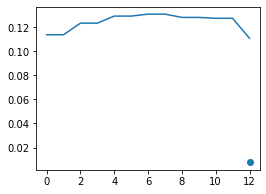

In [ ]:
plt.plot(x_train[0,:,2])

plt.scatter(12,y_train[0,:,2])
print(y_train[0,:,2])
print(x_train[0,:,2])

In [ ]:
train_dataloader = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(64)
val_dataloader = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(10000).batch(64)
test_dataloader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

train_batch_size = 2253
val_batch_size = 270
test_batch_size = 270

print(train_dataloader)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

<BatchDataset element_spec=(TensorSpec(shape=(None, 13, 1683), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1683), dtype=tf.float64, name=None))>


In [ ]:
def evaluate(dataloader, model, log=False):
    for traffic_batch, labels_batch in dataloader:
        traffic = traffic_batch
        print(traffic.shape)
        predict_flow = model(traffic)
        mse = tf.keras.losses.MeanSquaredError()
        mse = mse(labels_batch,predict_flow ).numpy()
    
    return predict_flow

In [ ]:
evaluate(test_dataloader,transformer)

(64, 13, 1683)
input_shape (64, 13, 1683)
try embedd (64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)
(64, 13, 1683)
input_shape (64, 13, 1683)
try embedd (64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)
(64, 13, 1683)
input_shape (64, 13, 1683)
try embedd (64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)
(64, 13, 1683)
input_shape (64, 13, 1683)
try embedd (64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)
(14, 13, 1683)
input_shape (14, 13, 1683)
try embedd (14, 13, 1683)

eh (14, 13, 1683)
(14, 13, 1683)

eh (14, 13, 1683)
(14, 13, 1683)


<tf.Tensor: shape=(14, 1683), dtype=float32, numpy=
array([[ 2.1078656 ,  1.4707577 ,  0.24937041, ..., -1.5736196 ,
        -0.34813488, -2.259883  ],
       [ 2.0983794 ,  1.4547632 ,  0.2851863 , ..., -1.594801  ,
        -0.31703827, -2.2555804 ],
       [ 2.1094072 ,  1.4592313 ,  0.3000597 , ..., -1.6126561 ,
        -0.30316862, -2.222311  ],
       ...,
       [ 2.1343682 ,  1.3320897 ,  0.5482021 , ..., -1.7556384 ,
        -0.67586446, -1.9976751 ],
       [ 2.210704  ,  1.3843462 ,  0.5623695 , ..., -1.7627736 ,
        -0.7669524 , -1.9749743 ],
       [ 2.2808592 ,  1.4373529 ,  0.52113485, ..., -1.7706354 ,
        -0.8728185 , -1.9244938 ]], dtype=float32)>

In [ ]:
def loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    y = mse(y_true, y_pred)
    return y_train

In [ ]:
transformer.compile(optimizer=optimizer, 
                  loss = tf.keras.losses.MeanSquaredError(), 
                  metrics= [tf.keras.losses.MeanSquaredError()]) 

In [ ]:
transformer.fit(train_dataloader,epochs = 7,validation_data = val_dataloader)

Epoch 1/7
input_shape (None, 13, 1683)
try embedd (None, 13, 1683)

eh (None, 13, 1683)
(None, 13, 1683)

eh (None, 13, 1683)
(None, 13, 1683)
input_shape (None, 13, 1683)
try embedd (None, 13, 1683)

eh (None, 13, 1683)
(None, 13, 1683)

eh (None, 13, 1683)
(None, 13, 1683)
36/36 [==============================] - ETA: 0s - loss: 28.2540 - mean_squared_error: 27.6596 input_shape (None, 13, 1683)
try embedd (None, 13, 1683)

eh (None, 13, 1683)
(None, 13, 1683)

eh (None, 13, 1683)
(None, 13, 1683)
36/36 [==============================] - 712s 19s/step - loss: 28.2540 - mean_squared_error: 27.6596 - val_loss: 0.6505 - val_mean_squared_error: 0.6494
Epoch 2/7
36/36 [==============================] - 712s 20s/step - loss: 0.5011 - mean_squared_error: 0.4960 - val_loss: 0.1150 - val_mean_squared_error: 0.1168
Epoch 3/7
36/36 [==============================] - 813s 23s/step - loss: 0.2511 - mean_squared_error: 0.2506 - val_loss: 0.1040 - val_mean_squared_error: 0.1090
Epoch 4/7
36/36 [====

In [ ]:
response = evaluate(test_dataloader,transformer)

In [ ]:
res = transformer.predict(x_test)
res[0]

In [ ]:
res2 = tf.reduce_mean(res,1)

In [ ]:
plt.plot(res2)
#plt.plot(tf.reduce_mean(y_test,2))

In [ ]:
print(max(res2))
print(min(res2))